In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [17]:
def enrichment_calc(enhancer_dict, trf_dict, seqlen):
    '''
    Calculate enrichment of STRs in enhancers.
    
    1. construct contingency table:
              
            | enhancer | not enhancer |
    -----------------------------------
    STR     |    q1    |      q2      |
    not STR |    q3    |      q4      |
    -----------------------------------
    
    2. calculate OR = q1*q4/(q2*q4)
    3. calculate std err = √(1/q1+1/q2+1/q3+1/q4)
    '''
    q1 = np.sum([len(np.intersect1d(enhancer_dict[x], trf_dict[x])) for x in enhancer_dict])
    q2 = np.sum([len(enhancer_dict[x]) - len(np.intersect1d(enhancer_dict[x], trf_dict[x])) for x in enhancer_dict])
    q3 = np.sum([len(trf_dict[x]) - len(np.intersect1d(enhancer_dict[x], trf_dict[x])) for x in enhancer_dict])
    q4 = seqlen - np.sum([q1, q2, q3])
    
    # calculate odds ratio
    OR = q1*q4/(q2*q3)
    # calculate standard error of OR
    stderr = np.sqrt((1/q1+1/q2+1/q3+1/q4))

    return OR, stderr

In [7]:
# load some basic info about human genome
chromsize_df = pd.read_csv('hg38.chrom.sizes.txt', delimiter='\t', names=['size']).drop('chrY')
chroms = list(chromsize_df.index)
genomesize = np.sum(chromsize_df.loc[chroms])[0]

## Load in data from TRF

In [8]:
# load in list of STRs in the genome
trf_dfs = {}
for chrom in chroms:
    trf_dfs[chrom] = pd.read_csv('/Users/connor/Documents/fordycelab/TRF/hg38/TRF_output/%s_repeats.csv' % chrom)
    
# organize STRs into dictionary with a list of genomic coordinates for each chromosome
trf_dict = {}
for chrom in tqdm(trf_dfs):
    trf_dfs[chrom] = trf_dfs[chrom][trf_dfs[chrom]['consensus_size']<5]
    trf_dict[chrom] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in trf_dfs[chrom].iterrows()])
    
trf_dict = {k: np.unique(v) for k,v in trf_dict.items()}

100%|█████████████████████████████████████████████| 23/23 [00:25<00:00,  1.09s/it]


### load enhancer annotations
sources:
- FANTOM5: https://fantom.gsc.riken.jp/5/
- Enhancer atlas: http://www.enhanceratlas.org/index.php
- HACER: http://bioinfo.vanderbilt.edu/AE/HACER/index.html

In [4]:
F5_df = pd.read_csv('enhancer_annotations/F5.hg38.enhancers.bed', delimiter='\t',names=['chr', 'start', 'end', 'name', 'score'], usecols=np.arange(5))
EA2_df = pd.read_csv('enhancer_annotations/hs_enhancers_hg38.bed', delimiter='\t',names=['chr', 'start', 'end'])
HACER_df = pd.read_csv('enhancer_annotations/HACER_hg38.bed', delimiter='\t', names=['chr', 'start', 'end'])

In [27]:
f5_dict = {}

for i in chroms:
    f5_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in F5_df[F5_df['chr']==i].iterrows()])
    
f5_dict = {k: np.unique(v) for k,v in f5_dict.items()}

In [28]:
ea2_dict = {}

for i in chroms:
    ea2_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in EA2_df[EA2_df['chr']==i].iterrows()])
    
ea2_dict = {k: np.unique(v) for k,v in ea2_dict.items()}

In [29]:
hacer_dict = {}

for i in chroms:
    hacer_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in HACER_df[HACER_df['chr']==i].iterrows()])

hacer_dict = {k: np.unique(v) for k,v in hacer_dict.items()}

#### dinucleotide-matched negatives

In [52]:
negatives = pd.read_csv('enhancer_annotations/F5.hg38.negatives.bed.0', '\t', names=['chr', 'start', 'end', 'classification'])
negatives = negatives[negatives['classification']==0]

neg_dict = {}

for i in chroms:
    neg_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in negatives[negatives['chr']==i].iterrows()])

F5_neg_dict = {k: np.unique(v) for k,v in neg_dict.items()}

/opt/homebrew/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
negatives = pd.read_csv('enhancer_annotations/EA2_negatives.bed.0', '\t', names=['chr', 'start', 'end', 'classification'])
negatives = negatives[negatives['classification']==0]

neg_dict = {}

for i in chroms:
    neg_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in negatives[negatives['chr']==i].iterrows()])

EA_neg_dict = {k: np.unique(v) for k,v in neg_dict.items()}

In [65]:
negatives = pd.read_csv('enhancer_annotations/HACER_negatives.bed.0', '\t', names=['chr', 'start', 'end', 'classification'])
negatives = negatives[negatives['classification']==0]

neg_dict = {}

for i in chroms:
    neg_dict[i] = np.hstack([np.arange(row['start'], row['end']+1) for i,row in negatives[negatives['chr']==i].iterrows()])

HACER_neg_dict = {k: np.unique(v) for k,v in neg_dict.items()}

# Calculate what percentage of enhancers contain an STR

In [9]:
def calculate_enhancer_STR_overlap(enhancer_df, trf_dict):
    '''
    given a dataframe with enhancer genome coordinates
    and a list of genomic repeats, returns the proportion
    of enhancers containing an STR
    '''
    enhancer_repeats = 0
    enhancer_total = len(enhancer_df)

    for i in tqdm(chroms):
        for j, row in enhancer_df[enhancer_df['chr']==i].iterrows():
            temp = trf_dict[i][trf_dict[i]>row['start']]
            temp = temp[temp<row['end']]
            if len(temp) > 0:
                enhancer_repeats += 1
    return enhancer_repeats/enhancer_total

In [10]:
# calculate enhancer/STR overlap for each enhancer database
f5_repeatoverlap = calculate_enhancer_STR_overlap(F5_df,trf_dict)
ea_repeatolverlap = calculate_enhancer_STR_overlap(EA2_df,trf_dict)
hacer_repeatoverlap = calculate_enhancer_STR_overlap(HACER_df,trf_dict)

100%|█████████████████████████████████████████████| 23/23 [04:09<00:00, 10.83s/it]


0.17468594453662006

In [25]:
np.mean([f5_repeatoverlap, ea_repeatolverlap, hacer_repeatoverlap])

0.24742167315321884

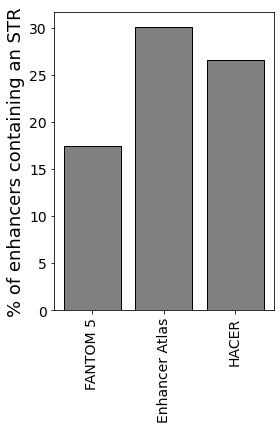

In [62]:
fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)

ax.bar(range(3), 100*np.array([f5_repeatoverlap, ea_repeatolverlap, hacer_repeatoverlap]),
       fc='gray', ec='k')

ax.set_xticks(range(3))
ax.set_xticklabels(['FANTOM 5', 'Enhancer Atlas', 'HACER'], rotation=90)
ax.tick_params(labelsize=14)

ax.set_ylabel('% of enhancers containing an STR', fontsize=18)

fig.tight_layout()
# fig.savefig('enhancer_STR_percentage.png')

# Calculate repeat enrichment in STRs

In [47]:
# calculate STR enrichment for enhancers for each database
F5_OR = enrichment_calc(f5_dict, trf_dict, genomesize)
EA_OR = enrichment_calc(ea2_dict, trf_dict, genomesize)
HACER_OR = enrichment_calc(hacer_dict, trf_dict, genomesize)

# calculate STR enrichment for non-enhancer regions matched on size and nucleotide composition
F5_negatives = enrichment_calc(F5_neg_dict, trf_dict, genomesize)
EA_negatives = enrichment_calc(EA_neg_dict, trf_dict, genomesize)
HACER_negatives = enrichment_calc(HACER_neg_dict, trf_dict, genomesize)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


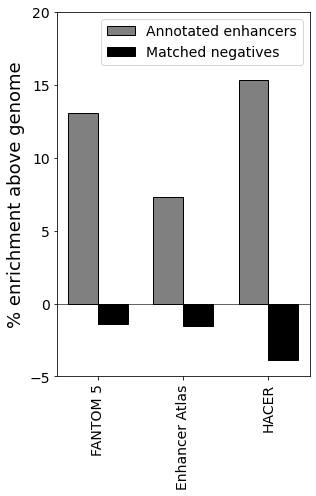

In [77]:
fig = plt.figure(figsize=(4.5,7))
ax = fig.add_subplot(111)

w = 0.35
ax.bar(np.arange(3)-w/2, 100*np.array([F5_OR, EA_OR, HACER_OR])[:,0]-100,
       fc='gray', ec='k', width=w)
ax.bar(np.arange(3)+w/2, 100*np.array([F5_negatives, EA_negatives, HACER_negatives])[:,0]-100,
       fc='black', ec='k', width=w)

ax.set_xticks(range(3))
ax.set_xticklabels(['FANTOM 5', 'Enhancer Atlas', 'HACER'], rotation=90)
ax.tick_params(labelsize=14)
ax.legend(['Annotated enhancers','Matched negatives'], fontsize=14)
ax.axhline(0,c='k',lw=0.6)
ax.set_ylim(-5,20)

ax.set_ylabel('% enrichment above genome', fontsize=18)

fig.tight_layout()
fig.savefig('enhancer_STR_enrichment.png')